# IMPORTING AND CLEANING BETTING DATASET (PINNACLE SPORTS)

imports and setup

In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score, roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np



In [2]:
betting_df=pd.read_csv("Final/usopen.csv")
betting_df=betting_df[['Date', 'Winner', 'Loser', 'WRank', 'LRank', 'Wsets', 'Lsets', 'Comment', 'PSW', 'PSL']]
betting_df = betting_df[betting_df['Loser'] != "Forbes M."] #we have to drop this row as there was missing data for this game in the original dataset so it's not present in the testset
betting_df

,Date,Winner,Loser,WRank,LRank,Wsets,Lsets,Comment,PSW,PSL
0,26/08/2024,Zverev A.,Marterer M.,4,100,3,1,Completed,1.02,27.72
1,26/08/2024,Bautista Agut R.,Nardi L.,67,90,3,0,Completed,1.28,4.10
2,26/08/2024,Comesana F.,Stricker D.,108,169,3,1,Completed,3.45,1.36
3,26/08/2024,Humbert U.,Monteiro T.,17,75,3,0,Completed,1.13,7.11
4,26/08/2024,Krueger M.,Grenier H.,179,173,3,1,Completed,1.73,2.25
...,...,...,...,...,...,...,...,...,...,...
122,04/09/2024,Draper J.,De Minaur A.,25,10,3,0,Completed,2.33,1.68
123,05/09/2024,Sinner J.,Medvedev D.,1,5,3,1,Completed,1.36,3.44
124,06/09/2024,Sinner J.,Draper J.,1,25,3,0,Completed,1.16,6.20
125,07/09/2024,Fritz T.,Tiafoe F.,12,20,3,2,Completed,1.34,3.60


computing Pinnacle implied probabilities, and margin

In [3]:
betting_df['winner_prob'], betting_df['loser_prob'] = 1/betting_df['PSW'], 1/betting_df['PSL']
betting_df['margin'] = betting_df['winner_prob'] + betting_df['loser_prob'] - 1
betting_df

,Date,Winner,Loser,WRank,LRank,Wsets,Lsets,Comment,PSW,PSL,winner_prob,loser_prob,margin
0,26/08/2024,Zverev A.,Marterer M.,4,100,3,1,Completed,1.02,27.72,0.980392,0.036075,0.016467
1,26/08/2024,Bautista Agut R.,Nardi L.,67,90,3,0,Completed,1.28,4.10,0.781250,0.243902,0.025152
2,26/08/2024,Comesana F.,Stricker D.,108,169,3,1,Completed,3.45,1.36,0.289855,0.735294,0.025149
3,26/08/2024,Humbert U.,Monteiro T.,17,75,3,0,Completed,1.13,7.11,0.884956,0.140647,0.025603
4,26/08/2024,Krueger M.,Grenier H.,179,173,3,1,Completed,1.73,2.25,0.578035,0.444444,0.022479
...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,04/09/2024,Draper J.,De Minaur A.,25,10,3,0,Completed,2.33,1.68,0.429185,0.595238,0.024423
123,05/09/2024,Sinner J.,Medvedev D.,1,5,3,1,Completed,1.36,3.44,0.735294,0.290698,0.025992
124,06/09/2024,Sinner J.,Draper J.,1,25,3,0,Completed,1.16,6.20,0.862069,0.161290,0.023359
125,07/09/2024,Fritz T.,Tiafoe F.,12,20,3,2,Completed,1.34,3.60,0.746269,0.277778,0.024046


# TRAINING 5 MODELS FROM PREVIOUS PART WITH OPTIMAL HYPERPARAMS FROM TEST DATA ONLY

Load train and test - valid not needed as validation & hyperparam tuning already done

In [4]:
# Load train and test data
train_data = pd.read_csv("Final/train.csv")
test_data = pd.read_csv("Final/test.csv")  

X_train = train_data.drop(columns=["result"])
y_train = train_data["result"]

X_test = test_data.drop(columns=["result"])
y_test = test_data["result"]

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}") #test on grand slam+rest of 2024 after it

Training samples: 58128
Test samples: 705


Log model

In [5]:
# Pipeline from log model
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logit", LogisticRegression(
        penalty="l2",
        C=1.0,
        solver="lbfgs",
        max_iter=2000,
        random_state=42
    ))
])

# Train on ALL training data
pipe.fit(X_train, y_train)

# Predict on test set
y_prob = pipe.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

# Evaluate
print("\n=== Logistic Regression Test Results ===")
print(f"Log Loss:  {log_loss(y_test, y_prob):.6f}")
print(f"Brier:     {brier_score_loss(y_test, y_prob):.6f}")
print(f"AUC:       {roc_auc_score(y_test, y_prob):.6f}")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.6f}")


=== Logistic Regression Test Results ===
Log Loss:  0.611812
Brier:     0.212544
AUC:       0.722119
Accuracy:  0.653901


XGB

In [6]:
# Best hyperparameters from tuning
best_params_ll = {
    'max_depth': 5,
    'learning_rate': 0.010944546677551579,
    'subsample': 0.9076971864318132,
    'colsample_bytree': 0.847899424542148,
    'min_child_weight': 4.697047917427967,
    'n_estimators': 642
}

best_params_err = {
    'max_depth': 4,
    'learning_rate': 0.0041203103322660735,
    'subsample': 0.6888651281360453,
    'colsample_bytree': 0.8960845657731566,
    'min_child_weight': 7.161503421193317,
    'n_estimators': 1017
}

# XGBoost Log Loss Optimized
model_ll = XGBClassifier(
    **best_params_ll,
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

model_ll.fit(X_train, y_train)
y_prob_ll = model_ll.predict_proba(X_test)[:, 1]
y_pred_ll = (y_prob_ll >= 0.5)

print("=== XGBoost (Log Loss Tuned) ===")
print(f"Log Loss:  {log_loss(y_test, y_prob_ll):.6f}")
print(f"Brier:     {brier_score_loss(y_test, y_prob_ll):.6f}")
print(f"AUC:       {roc_auc_score(y_test, y_prob_ll):.6f}")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_ll):.6f}")

# XGBoost Error Rate Optimized
model_err = XGBClassifier(
    **best_params_err,
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

model_err.fit(X_train, y_train)
y_prob_err = model_err.predict_proba(X_test)[:, 1]
y_pred_err = (y_prob_err >= 0.5)

print("\n=== XGBoost (Error Tuned) ===")
print(f"Log Loss:  {log_loss(y_test, y_prob_err):.6f}")
print(f"Brier:     {brier_score_loss(y_test, y_prob_err):.6f}")
print(f"AUC:       {roc_auc_score(y_test, y_prob_err):.6f}")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_err):.6f}")

=== XGBoost (Log Loss Tuned) ===
Log Loss:  0.606898
Brier:     0.209555
AUC:       0.730470
Accuracy:  0.672340

=== XGBoost (Error Tuned) ===
Log Loss:  0.605467
Brier:     0.209420
AUC:       0.730486
Accuracy:  0.669504


MLP

In [7]:
def test_mlp(X_train, y_train, X_test, y_test, params, name):
    torch.manual_seed(42)
    
    # Scale
    scaler = StandardScaler()
    X_tr = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
    X_te = torch.tensor(scaler.transform(X_test), dtype=torch.float32)
    y_tr = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    
    # Model
    d = params['dropout']
    model = nn.Sequential(
        nn.Linear(X_tr.shape[1], 256), nn.ReLU(), nn.Dropout(d),
        nn.Linear(256, 256), nn.ReLU(), nn.Dropout(d),
        nn.Linear(256, 256), nn.ReLU(), nn.Dropout(d),
        nn.Linear(256, 256), nn.ReLU(), nn.Dropout(d),
        nn.Linear(256, 1)
    )
    
    # Train
    optimizer = optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_tr, y_tr), 
        batch_size=params['batch_size'], shuffle=True
    )
    
    model.train()
    for _ in range(params['n_epochs']):
        for xb, yb in loader:
            optimizer.zero_grad()
            loss = nn.BCEWithLogitsLoss()(model(xb), yb)
            loss.backward()
            optimizer.step()
    
    # Predict
    model.eval()
    with torch.no_grad():
        y_prob = torch.sigmoid(model(X_te)).squeeze().numpy()
    y_pred = (y_prob >= 0.5).astype(int)
    
    # Results
    print(f"\n=== {name} ===")
    print(f"Log Loss:  {log_loss(y_test, y_prob):.6f}")
    print(f"Brier:     {brier_score_loss(y_test, y_prob):.6f}")
    print(f"AUC:       {roc_auc_score(y_test, y_prob):.6f}")
    print(f"Accuracy:  {accuracy_score(y_test, y_pred):.6f}")

    return model, scaler

# Run both with best hyperparams found previously
best_ll = {'lr': 0.000533853641534584, 'weight_decay': 4.398017180584654e-06, 'dropout': 0.42515080111029613, 'batch_size': 256, 'n_epochs': 8}
best_err = {'lr': 0.00018232149103426372, 'weight_decay': 2.5161801333744398e-06, 'dropout': 0.45477228794276553, 'batch_size': 256, 'n_epochs': 13}

mlp_ll_model, mlp_ll_scaler = test_mlp(X_train, y_train, X_test, y_test, best_ll, "MLP (Log Loss Tuned)")
mlp_err_model, mlp_err_scaler = test_mlp(X_train, y_train, X_test, y_test, best_err, "MLP (Error Tuned)")


=== MLP (Log Loss Tuned) ===
Log Loss:  0.611301
Brier:     0.211555
AUC:       0.725215
Accuracy:  0.663830

=== MLP (Error Tuned) ===
Log Loss:  0.609818
Brier:     0.211291
AUC:       0.723259
Accuracy:  0.660993


# STRATEGY

align both datasets

In [8]:
order=pd.read_csv("Final/order.csv") #we need to align games of betting df to our test set
order_l=list(zip(order['winner_rank'], order['loser_rank']))
s=0
rows = []
for i in order_l:
    row = betting_df[(betting_df['WRank'] == i[0]) & (betting_df['LRank'] == i[1])] #unique
    rows.append(row.iloc[0])
    s+=len(row)
print(s) #126 as needed (remember 1 missing row, so no other missing or duplicate matches!)
betting_df_ordered = pd.DataFrame(rows).reset_index(drop=True)

126


In [9]:
betting_df_ordered

,Date,Winner,Loser,WRank,LRank,Wsets,Lsets,Comment,PSW,PSL,winner_prob,loser_prob,margin
0,27/08/2024,Sinner J.,Mcdonald M.,1,140,3,1,Completed,1.02,28.96,0.980392,0.034530,0.014923
1,27/08/2024,Michelsen A.,Spizzirri E.,49,341,3,0,Completed,1.24,4.63,0.806452,0.215983,0.022434
2,28/08/2024,Bellucci M.,Wawrinka S.,101,176,3,0,Completed,1.40,3.20,0.714286,0.312500,0.026786
3,27/08/2024,O Connell C.,Jarry N.,87,26,3,1,Completed,2.84,1.49,0.352113,0.671141,0.023254
4,27/08/2024,Fils A.,Tien L.,24,191,3,1,Completed,1.35,3.50,0.740741,0.285714,0.026455
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,03/09/2024,Fritz T.,Zverev A.,12,4,3,1,Completed,2.49,1.61,0.401606,0.621118,0.022724
122,04/09/2024,Tiafoe F.,Dimitrov G.,20,9,2,1,Retired,2.44,1.63,0.409836,0.613497,0.023333
123,06/09/2024,Sinner J.,Draper J.,1,25,3,0,Completed,1.16,6.20,0.862069,0.161290,0.023359
124,07/09/2024,Fritz T.,Tiafoe F.,12,20,3,2,Completed,1.34,3.60,0.746269,0.277778,0.024046


In [10]:
test_slam=test_data.iloc[0:126] #testing strategy only on last grand slam
test_slam

,draw_size,best_of,ATP_Point_Diff,Rank_Diff,Height_Diff,Age_Diff,H2H_Diff,H2H_Surface_Diff,N_Games_Diff,Win_Rate_3_Diff,...,p_1stIn_diff_last_2000,p_1stWon_diff_last_2000,p_2ndWon_diff_last_2000,p_bpSaved_diff_last_2000,p_bpConv_diff_last_2000,p_rpw_diff_last_2000,p_acedAgainst_diff_last_2000,p_totalPtsWon_diff_last_2000,p_dominanceRatio_diff_last_2000,result
0,128,5,-8938.0,139.0,-13.0,6.3,-2.0,-1.0,-90.0,-1.000000,...,0.040335,-0.060441,-0.039738,-0.059859,-0.037054,-0.032386,0.009722,-0.037964,-0.280750,0.0
1,128,5,-970.0,292.0,-10.0,2.6,-0.0,-0.0,-59.0,-0.166667,...,-0.053786,0.050586,0.006958,0.043966,0.032540,-0.018582,-0.044996,-0.006011,-0.029277,0.0
2,128,5,-222.0,75.0,8.0,16.2,-0.0,-0.0,882.0,-0.000000,...,-0.052375,-0.007273,0.034970,0.002619,0.134458,0.037642,-0.068101,0.020022,0.153696,0.0
3,128,5,-1004.0,61.0,-18.0,1.4,0.0,0.0,-104.0,0.333333,...,-0.016709,-0.015879,-0.002571,-0.010613,-0.073161,-0.002004,0.031055,-0.011350,-0.103109,1.0
4,128,5,-1461.0,167.0,-5.0,-1.5,-0.0,-0.0,-80.0,0.333333,...,0.073136,-0.124586,-0.033377,0.019507,-0.043978,0.019707,0.008924,-0.023871,-0.157248,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,128,5,3915.0,-8.0,2.0,0.5,1.0,-1.0,181.0,-0.000000,...,0.067369,-0.019160,-0.041751,-0.005328,0.038992,0.023424,-0.022903,0.007721,0.083079,0.0
122,128,5,-1535.0,11.0,-3.0,-6.7,-1.0,0.0,-343.0,0.000000,...,-0.011319,-0.025198,0.007661,-0.001766,-0.021651,-0.020461,0.042903,-0.016559,-0.158489,1.0
123,128,5,7665.0,-24.0,-2.0,0.4,-1.0,0.0,203.0,0.000000,...,0.001621,-0.027807,0.012493,0.010717,0.015970,0.023377,-0.011594,0.009174,0.016856,1.0
124,128,5,1000.0,-8.0,8.0,0.3,5.0,5.0,65.0,0.000000,...,-0.010726,0.038313,0.007366,0.002622,0.008596,0.009168,-0.032897,0.015363,0.141133,1.0


Strategy 1 (all in on predicted winner) & strategy 2 (hedge bets if higher than a certain threshold)

In [11]:
#tracking strat 1
log_reg_cum, xgb_ll_cum, xgb_err_cum, mlp_ll_cum, mlp_err_cum={'Staked':[], 'Winnings':[], 'Prob':[], 'Act':[]}, {'Staked':[], 'Winnings':[], 'Prob':[], 'Act':[]}, {'Staked':[], 'Winnings':[], 'Prob':[], 'Act':[]}, {'Staked':[], 'Winnings':[], 'Prob':[], 'Act':[]}, {'Staked':[], 'Winnings':[], 'Prob':[], 'Act':[]}
#tracking strat 2
log_reg_cum2, xgb_ll_cum2, xgb_err_cum2, mlp_ll_cum2, mlp_err_cum2={'Staked':[], 'Winnings':[], 'Prob':[], 'Act':[], 'Thresh':[], 'Dist':[]},{'Staked':[], 'Winnings':[], 'Prob':[], 'Act':[], 'Thresh':[], 'Dist':[]},{'Staked':[], 'Winnings':[], 'Prob':[], 'Act':[], 'Thresh':[], 'Dist':[]},{'Staked':[], 'Winnings':[], 'Prob':[], 'Act':[], 'Thresh':[], 'Dist':[]},{'Staked':[], 'Winnings':[], 'Prob':[], 'Act':[], 'Thresh':[], 'Dist':[]}
bet_size=100 #100 per bet

# function to update betting stats
def update_betting_stats(dic, winnings, staked, prob, outcome, thresh=None, dist=None):
    dic['Winnings'].append(winnings)
    dic['Staked'].append(staked)
    if staked>0: #only add probabilities when we placed a bet
        dic['Prob'].append(prob)
        dic['Act'].append(outcome)
    if thresh is not None: #for strat 2
        dic['Thresh'].append(thresh)
        dic['Dist'].append(dist)
    return dic

Run betting simulation

In [12]:
for idx, match in test_slam.iterrows(): #run through all games in grand slam
    w_odds = betting_df_ordered.iloc[idx]['PSW']
    win_ret = w_odds*bet_size
    row = match.drop('result').to_frame().T  # Keeps column names
    actual = match['result']
    p1_prob=betting_df_ordered.iloc[idx]['winner_prob'] if actual==1 else betting_df_ordered.iloc[idx]['loser_prob']
    p2_prob=betting_df_ordered.iloc[idx]['winner_prob'] if actual==0 else betting_df_ordered.iloc[idx]['loser_prob']
    margin=betting_df_ordered.iloc[idx]['margin']
    required_dist=((margin*p1_prob*p2_prob)**0.5)/(1+margin) #for strategy 2, our model's predicted probability-implied probability needs to exceed this margin
    
    # Logistic Regression
    prob_lr = pipe.predict_proba(row)[:, 1][0]
    
    # XGBoost
    prob_xgb_ll = model_ll.predict_proba(row)[:, 1][0]
    prob_xgb_err = model_err.predict_proba(row)[:, 1][0]
    
    # MLP Log Loss
    row_scaled_ll = torch.tensor(mlp_ll_scaler.transform(row), dtype=torch.float32)
    mlp_ll_model.eval()
    with torch.no_grad():
        prob_mlp_ll = torch.sigmoid(mlp_ll_model(row_scaled_ll)).item()
    
    # MLP Error
    row_scaled_err = torch.tensor(mlp_err_scaler.transform(row), dtype=torch.float32)
    mlp_err_model.eval()
    with torch.no_grad():
        prob_mlp_err = torch.sigmoid(mlp_err_model(row_scaled_err)).item()

    # Compute if distance is far enough for strategy 2
    log_dist, xgb_ll_dist, xgb_err_dist, mlp_ll_dist, mlp_err_dist = prob_lr-(p1_prob/(1+margin)), prob_xgb_ll-(p1_prob/(1+margin)), prob_xgb_err-(p1_prob/(1+margin)), prob_mlp_ll-(p1_prob/(1+margin)), prob_mlp_err-(p1_prob/(1+margin))
    ev_log, ev_xgb_ll, ev_xgb_err, ev_mlp_ll, ev_mlp_err=abs(log_dist)>required_dist, abs(xgb_ll_dist)>required_dist, abs(xgb_err_dist)>required_dist, abs(mlp_ll_dist)>required_dist, abs(mlp_err_dist)>required_dist
    
    strat1=[win_ret if (prob_lr >= 0.5) == actual else 0,
            win_ret if (prob_xgb_ll >= 0.5) == actual else 0,
            win_ret if (prob_xgb_err >= 0.5) == actual else 0,
            win_ret if (prob_mlp_ll >= 0.5) == actual else 0,
            win_ret if (prob_mlp_err >= 0.5) == actual else 0] #winning return if we predicted on the right player to win (act=1 means p1 win, act=0 means p2 win)
    
    strat2=[0 if not ev_log else (win_ret * (1-prob_lr) if actual==0 else win_ret*prob_lr),
            0 if not ev_xgb_ll else (win_ret * (1-prob_xgb_ll) if actual==0 else win_ret*prob_xgb_ll),
            0 if not ev_xgb_err else (win_ret * (1-prob_xgb_err) if actual==0 else win_ret*prob_xgb_err),
            0 if not ev_mlp_ll else (win_ret * (1-prob_mlp_ll) if actual==0 else win_ret*prob_mlp_ll),
            0 if not ev_mlp_err else (win_ret * (1-prob_mlp_err) if actual==0 else win_ret*prob_mlp_err)] #winning return * predicted win probability (hedged) if we met strat 2 requirement else 0 (we don't bet otherwise)
    
    print(f"\n=== Match {idx} | Actual: {'P1 Win' if actual == 1 else 'P2 Win'} ===") #match by match breakdown per model per strategy
    print(f"Strat 2 requirement threshold: {required_dist:.6f} | Winner odds: {w_odds} | Loser odds: {betting_df_ordered.iloc[idx]['PSL']} | Margin: {margin:.6f} | P1 Prob: {p1_prob:.6f} | P2 Prob: {p2_prob:.6f}")
    print(f"LogReg:      P1 Win: {prob_lr:.2%} | P2 Win: {1-prob_lr:.2%} | Pred: {'P1' if prob_lr >= 0.5 else 'P2'} {'✓' if (prob_lr >= 0.5) == actual else '✗'} | Strat1: {round(strat1[0]-bet_size,2)} | Strat2: {round(strat2[0]-(bet_size if ev_log else 0),2)} | Strat2 Distance: {log_dist:.6f} | Requirement Met: {'✓' if ev_log else '✗'}")
    print(f"XGB (LL):    P1 Win: {prob_xgb_ll:.2%} | P2 Win: {1-prob_xgb_ll:.2%} | Pred: {'P1' if prob_xgb_ll >= 0.5 else 'P2'} {'✓' if (prob_xgb_ll >= 0.5) == actual else '✗'} | Strat1: {round(strat1[1]-bet_size,2)} | Strat2: {round(strat2[1]-(bet_size if ev_xgb_ll else 0),2)} | Strat2 Distance: {xgb_ll_dist:.6f} | Requirement Met: {'✓' if ev_xgb_ll else '✗'}")
    print(f"XGB (Err):   P1 Win: {prob_xgb_err:.2%} | P2 Win: {1-prob_xgb_err:.2%} | Pred: {'P1' if prob_xgb_err >= 0.5 else 'P2'} {'✓' if (prob_xgb_err >= 0.5) == actual else '✗'} | Strat1: {round(strat1[2]-bet_size,2)} | Strat2: {round(strat2[2]-(bet_size if ev_xgb_err else 0),2)} | Strat2 Distance: {xgb_err_dist:.6f} | Requirement Met: {'✓' if ev_xgb_err else '✗'}")
    print(f"MLP (LL):    P1 Win: {prob_mlp_ll:.2%} | P2 Win: {1-prob_mlp_ll:.2%} | Pred: {'P1' if prob_mlp_ll >= 0.5 else 'P2'} {'✓' if (prob_mlp_ll >= 0.5) == actual else '✗'} | Strat1: {round(strat1[3]-bet_size,2)} | Strat2: {round(strat2[3]-(bet_size if ev_mlp_ll else 0),2)} | Strat2 Distance: {mlp_ll_dist:.6f} | Requirement Met: {'✓' if ev_mlp_ll else '✗'}")
    print(f"MLP (Err):   P1 Win: {prob_mlp_err:.2%} | P2 Win: {1-prob_mlp_err:.2%} | Pred: {'P1' if prob_mlp_err >= 0.5 else 'P2'} {'✓' if (prob_mlp_err >= 0.5) == actual else '✗'} | Strat1: {round(strat1[4]-bet_size,2)} | Strat2: {round(strat2[4]-(bet_size if ev_mlp_err else 0),2)} | Strat2 Distance: {mlp_err_dist:.6f} | Requirement Met: {'✓' if ev_mlp_err else '✗'}")
    
    # update strat 1
    update_betting_stats(log_reg_cum, strat1[0], bet_size, prob_lr, actual)
    update_betting_stats(xgb_ll_cum, strat1[1], bet_size, prob_xgb_ll, actual)
    update_betting_stats(xgb_err_cum, strat1[2], bet_size, prob_xgb_err, actual)
    update_betting_stats(mlp_ll_cum, strat1[3], bet_size, prob_mlp_ll, actual)
    update_betting_stats(mlp_err_cum, strat1[4], bet_size, prob_mlp_err, actual)
    # update strat 2
    update_betting_stats(log_reg_cum2, strat2[0], bet_size if ev_log else 0, prob_lr, actual, required_dist, abs(log_dist))
    update_betting_stats(xgb_ll_cum2, strat2[1], bet_size if ev_xgb_ll else 0, prob_xgb_ll, actual, required_dist, abs(xgb_ll_dist))
    update_betting_stats(xgb_err_cum2, strat2[2], bet_size if ev_xgb_err else 0, prob_xgb_err, actual, required_dist, abs(xgb_err_dist))
    update_betting_stats(mlp_ll_cum2, strat2[3], bet_size if ev_mlp_ll else 0, prob_mlp_ll, actual, required_dist, abs(mlp_ll_dist))
    update_betting_stats(mlp_err_cum2, strat2[4], bet_size if ev_mlp_err else 0, prob_mlp_err, actual, required_dist, abs(mlp_err_dist))


=== Match 0 | Actual: P2 Win ===
Strat 2 requirement threshold: 0.022146 | Winner odds: 1.02 | Loser odds: 28.96 | Margin: 0.014923 | P1 Prob: 0.034530 | P2 Prob: 0.980392
LogReg:      P1 Win: 4.02% | P2 Win: 95.98% | Pred: P2 ✓ | Strat1: 2.0 | Strat2: 0 | Strat2 Distance: 0.006220 | Requirement Met: ✗
XGB (LL):    P1 Win: 5.38% | P2 Win: 94.62% | Pred: P2 ✓ | Strat1: 2.0 | Strat2: 0 | Strat2 Distance: 0.019767 | Requirement Met: ✗
XGB (Err):   P1 Win: 7.71% | P2 Win: 92.29% | Pred: P2 ✓ | Strat1: 2.0 | Strat2: -5.87 | Strat2 Distance: 0.043094 | Requirement Met: ✓
MLP (LL):    P1 Win: 3.57% | P2 Win: 96.43% | Pred: P2 ✓ | Strat1: 2.0 | Strat2: 0 | Strat2 Distance: 0.001698 | Requirement Met: ✗
MLP (Err):   P1 Win: 5.10% | P2 Win: 94.90% | Pred: P2 ✓ | Strat1: 2.0 | Strat2: 0 | Strat2 Distance: 0.016954 | Requirement Met: ✗

=== Match 1 | Actual: P2 Win ===
Strat 2 requirement threshold: 0.061139 | Winner odds: 1.24 | Loser odds: 4.63 | Margin: 0.022434 | P1 Prob: 0.215983 | P2 Prob: 

Evaluation criteria for the models and strategies

In [13]:
results = [] #empty df to hold results in nice format
cum_profs=[] #cumulative profit lists for each model/strategy

#compute metrics for each model/strategy
for i in [log_reg_cum, xgb_ll_cum, xgb_err_cum, mlp_ll_cum, mlp_err_cum, log_reg_cum2, xgb_ll_cum2, xgb_err_cum2, mlp_ll_cum2, mlp_err_cum2]:
    prof_lst=[i['Winnings'][j]-i['Staked'][j] for j in range(len(i['Winnings'])) if i['Staked'][j]>0] #profit list for each game where we placed a bet
    wins_sum=sum([j for j in prof_lst if j>0])
    lose_sum=sum([j for j in prof_lst if j<=0])*-1 #amount lost in total (positive)
    MACE=(sum([abs(i['Prob'][k]-i['Act'][k]) for k in range(len(i['Prob']))]))/len(i['Prob']) #mean absolute calibration error
    cum_prof_lst=[]
    cum_prof=0
    for p in prof_lst: #compute cumulative profit for each model/strategy
        cum_prof+=p
        cum_prof_lst.append(cum_prof)
    cum_profs.append(cum_prof_lst) #store for later
    #max drawdown
    max_drawdown = 0
    peak = cum_prof_lst[0]
    for x in cum_prof_lst:
        if x > peak:
            peak = x
        drawdown = peak - x
        if drawdown > max_drawdown:
            max_drawdown = drawdown
    prof=sum(prof_lst)
    staked=sum(i['Staked'])
    n_bets=len(prof_lst)
    n_wins=len([j for j in prof_lst if j>0])
    avg_prof=prof/n_bets
    volatility=((1/(n_bets-1))*sum([(prof_lst[j]-avg_prof)**2 for j in range(n_bets)]))**0.5
    results.append({
    'Bets': n_bets,
    'Win Rate': n_wins/n_bets * 100,
    'ROI': prof/staked * 100,
    'Avg Profit': avg_prof,
    'Sharpe': avg_prof/volatility,
    'Max Drawdown': max_drawdown,
    'Profit Factor': wins_sum/lose_sum,
    'MACE': MACE*100,
    'Volatility': volatility
    })

model_names = ['LogReg_S1', 'XGB_LL_S1', 'XGB_Err_S1', 'MLP_LL_S1', 'MLP_Err_S1',
               'LogReg_S2', 'XGB_LL_S2', 'XGB_Err_S2', 'MLP_LL_S2', 'MLP_Err_S2']
df_results = pd.DataFrame(results, index=model_names).T
df_results = df_results.round(2) #print results nicely
df_results

,LogReg_S1,XGB_LL_S1,XGB_Err_S1,MLP_LL_S1,MLP_Err_S1,LogReg_S2,XGB_LL_S2,XGB_Err_S2,MLP_LL_S2,MLP_Err_S2
Bets,126.00,126.00,126.00,126.00,126.00,50.00,56.00,52.00,55.00,60.00
Win Rate,70.63,73.81,73.02,73.81,73.81,30.00,32.14,25.00,41.82,33.33
ROI,-5.07,0.48,-2.67,1.06,0.88,-2.88,-4.55,-4.08,-5.27,-4.80
Avg Profit,-5.07,0.48,-2.67,1.06,0.88,-2.88,-4.55,-4.08,-5.27,-4.80
Sharpe,-0.07,0.01,-0.04,0.02,0.01,-0.11,-0.20,-0.17,-0.18,-0.20
Max Drawdown,758.00,547.00,788.00,541.00,428.00,157.25,322.48,272.81,338.55,332.66
Profit Factor,0.83,1.02,0.90,1.04,1.03,0.77,0.63,0.66,0.66,0.63
MACE,37.11,36.40,37.17,35.83,36.49,41.61,38.40,37.14,43.56,39.17
Volatility,67.69,66.96,64.17,67.68,67.50,27.21,22.69,24.60,29.39,24.39


While our models mainly did not achieve profitability against Pinnacle's efficient market, a profit factor of over 0.9 for the strongest models demonstrates meaningful predictive power. The models successfully learned patterns that closely approximate professional bookmaker odds using only publicly available data. Closing the remaining 10% gap would likely require proprietary data sources or real-time market information.

# PLOTS

Equity curve

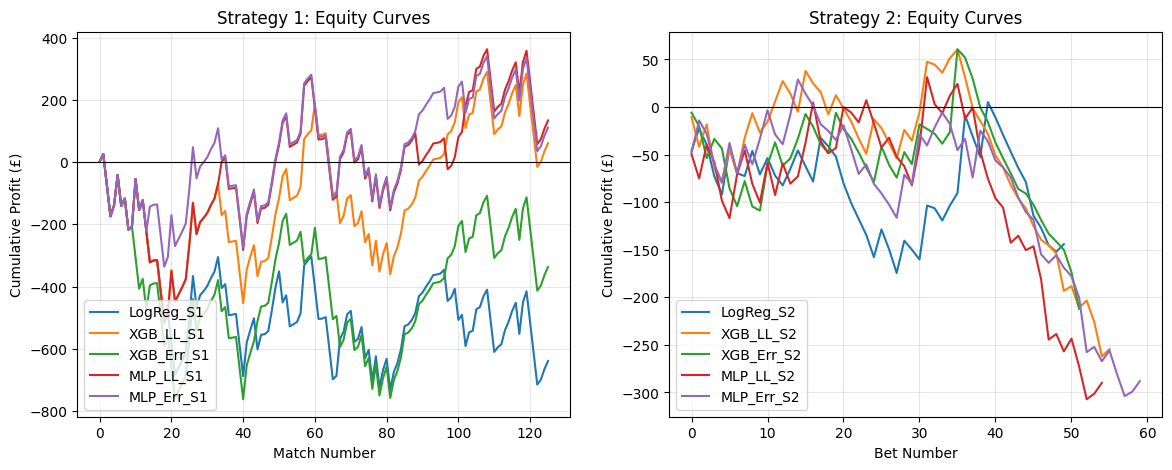

In [14]:
#Strategy 1 equity curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

strat1_data = [log_reg_cum, xgb_ll_cum, xgb_err_cum, mlp_ll_cum, mlp_err_cum]
strat1_models = ['LogReg_S1', 'XGB_LL_S1', 'XGB_Err_S1', 'MLP_LL_S1', 'MLP_Err_S1']

for i, name in enumerate(strat1_models):
    axes[0].plot(cum_profs[i], label=name, linewidth=1.5)

axes[0].axhline(y=0, color='black', linewidth=0.8)
axes[0].set_xlabel('Match Number')
axes[0].set_ylabel('Cumulative Profit (£)')
axes[0].set_title('Strategy 1: Equity Curves')
axes[0].legend(loc='lower left')
axes[0].grid(True, alpha=0.3)

# Strategy 2 equity curves
strat2_data = [log_reg_cum2, xgb_ll_cum2, xgb_err_cum2, mlp_ll_cum2, mlp_err_cum2]
strat2_models = ['LogReg_S2', 'XGB_LL_S2', 'XGB_Err_S2', 'MLP_LL_S2', 'MLP_Err_S2']

for i, name in enumerate(strat2_models):
    axes[1].plot(cum_profs[i+5], label=name, linewidth=1.5)

axes[1].axhline(y=0, color='black', linewidth=0.8)
axes[1].set_xlabel('Bet Number')
axes[1].set_ylabel('Cumulative Profit (£)')
axes[1].set_title('Strategy 2: Equity Curves')
axes[1].legend(loc='lower left')
axes[1].grid(True, alpha=0.3)

plt.show()

Key metrics

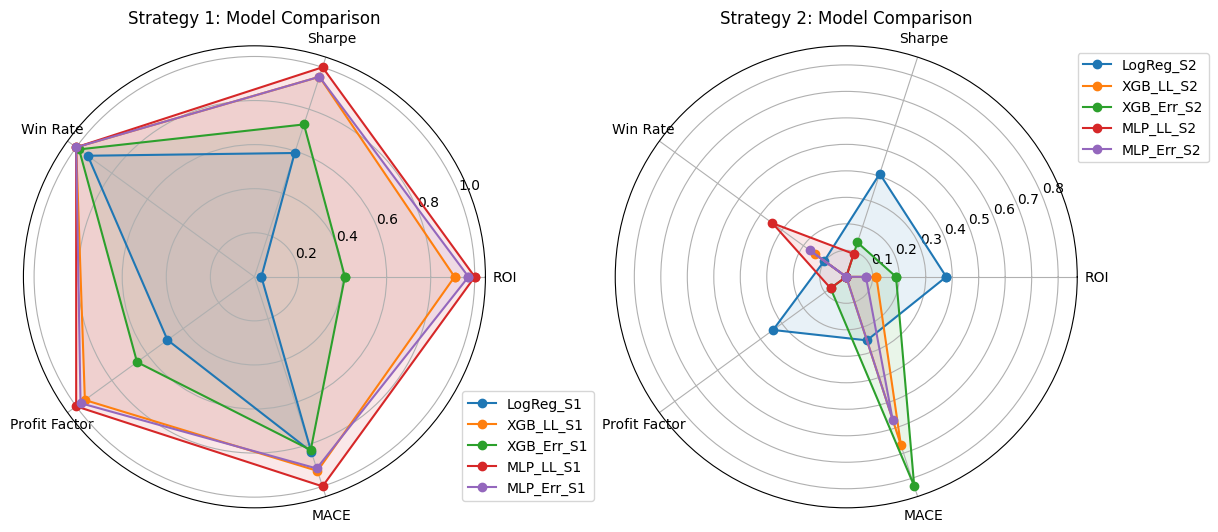

In [15]:
# Metrics to include, we invert MACE since lower is better
metrics = ['ROI', 'Sharpe', 'Win Rate', 'Profit Factor', 'MACE']

fig, axes = plt.subplots(1, 2, figsize=(14, 6), subplot_kw=dict(polar=True))

# Number of metrics
num_metrics = len(metrics)
angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
angles += angles[:1]  # Close the loop

# Normalise function (min-max scaling)
def normalise(values, invert=False):
    min_v, max_v = min(values), max(values)
    if max_v == min_v:
        return [0.5] * len(values)
    norm = [(v - min_v) / (max_v - min_v) for v in values]
    if invert:
        norm = [1 - n for n in norm]
    return norm

# Get normalised values for all models
all_models = strat1_models + strat2_models
roi_norm = normalise(df_results.loc['ROI'].values)
sharpe_norm = normalise(df_results.loc['Sharpe'].values)
wr_norm = normalise(df_results.loc['Win Rate'].values)
pf_norm = normalise(df_results.loc['Profit Factor'].values)
mace_norm = normalise(df_results.loc['MACE'].values, invert=True)  # Lower is better

# Strategy 1
for i, model in enumerate(zip(strat1_models)):
    values = [roi_norm[i], sharpe_norm[i], wr_norm[i], pf_norm[i], mace_norm[i]]
    values += values[:1]
    axes[0].plot(angles, values, 'o-', label=model)
    axes[0].fill(angles, values, alpha=0.1)

axes[0].set_xticks(angles[:-1])
axes[0].set_xticklabels(metrics)
axes[0].set_title('Strategy 1: Model Comparison')
axes[0].legend(loc='lower right', bbox_to_anchor=(1.25, 0))

# Strategy 2
for i, model in enumerate(zip(strat2_models)):
    values = [roi_norm[i+5], sharpe_norm[i+5], wr_norm[i+5], pf_norm[i+5], mace_norm[i+5]]
    values += values[:1]
    axes[1].plot(angles, values, 'o-', label=model)
    axes[1].fill(angles, values, alpha=0.1)

axes[1].set_xticks(angles[:-1])
axes[1].set_xticklabels(metrics)
axes[1].set_title('Strategy 2: Model Comparison')
axes[1].legend(loc='upper right', bbox_to_anchor=(1.3, 1))

plt.show()

Calib curve

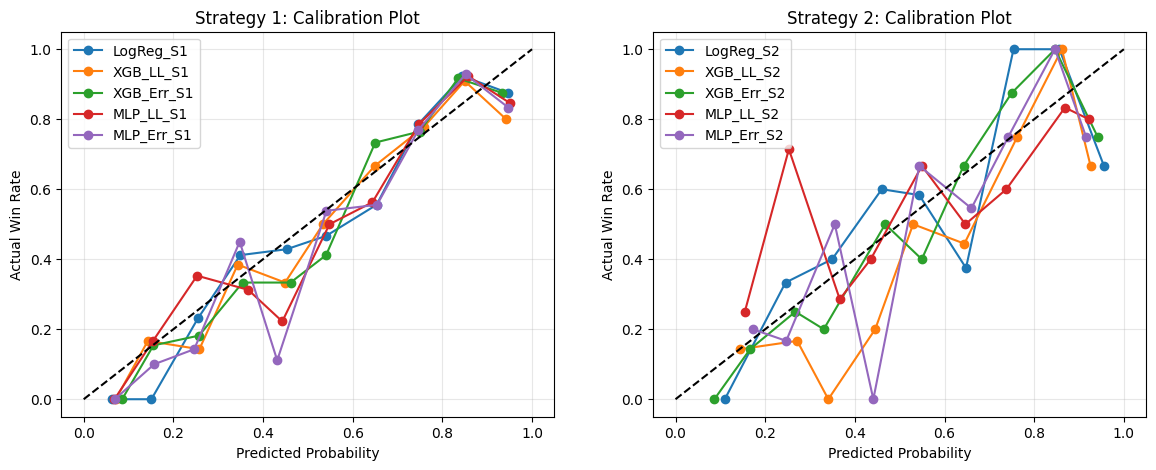

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Strategy 1
for data, name in zip(strat1_data, strat1_models):
    prob_true, prob_pred = calibration_curve(data['Act'], data['Prob'], n_bins=10)
    axes[0].plot(prob_pred, prob_true, label=name, linewidth=1.5, marker='o')

axes[0].plot([0,1], [0,1], 'k--')
axes[0].set_xlabel('Predicted Probability')
axes[0].set_ylabel('Actual Win Rate')
axes[0].set_title('Strategy 1: Calibration Plot')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Strategy 2
for data, name in zip(strat2_data, strat2_models):
    prob_true, prob_pred = calibration_curve(data['Act'], data['Prob'], n_bins=10)
    axes[1].plot(prob_pred, prob_true, label=name, linewidth=1.5, marker='o')

axes[1].plot([0,1], [0,1], 'k--')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Actual Win Rate')
axes[1].set_title('Strategy 2: Calibration Plot')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.show()

Threshold Distances for strategy 2
Model mostly agrees with Pinnacle, lack of edge due to small differences and it being wrong more than right on these ones. Few high conviction bets.

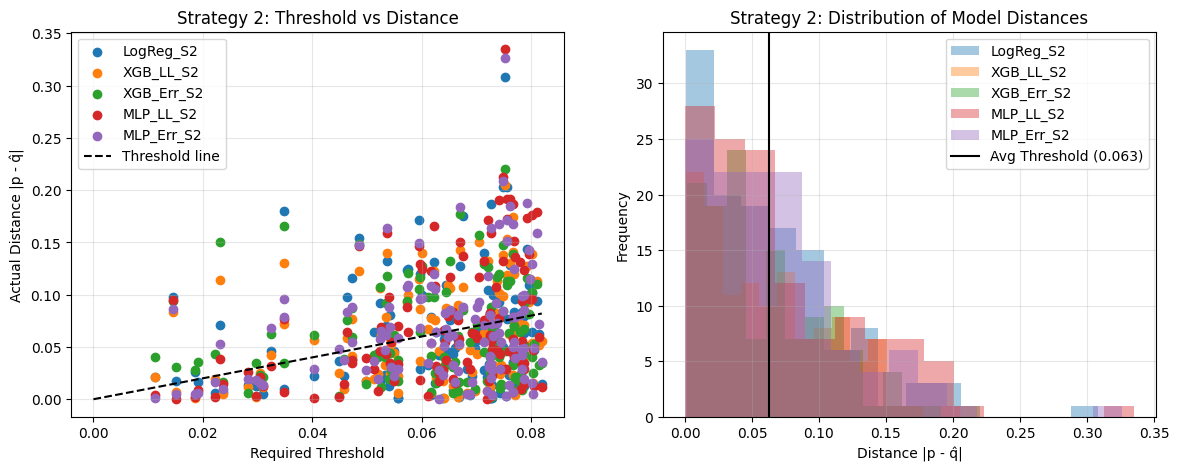

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Threshold vs Distance scatter
for data, name in zip(strat2_data, strat2_models):
    axes[0].scatter(data['Thresh'], data['Dist'], label=name)
    max_thresh = max(data['Thresh'])

axes[0].plot([0, max_thresh], [0, max_thresh], 'k--', label='Threshold line')
axes[0].set_xlabel('Required Threshold')
axes[0].set_ylabel('Actual Distance |p - q̂|')
axes[0].set_title('Strategy 2: Threshold vs Distance')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Histogram of distances with threshold overlay
for data, name in zip(strat2_data, strat2_models):
    axes[1].hist(data['Dist'], bins=15, alpha=0.4, label=name)

avg_thresh = sum(strat2_data[0]['Thresh']) / len(strat2_data[0]['Thresh'])
axes[1].axvline(x=avg_thresh, color='black', label=f'Avg Threshold ({avg_thresh:.3f})')
axes[1].set_xlabel('Distance |p - q̂|')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Strategy 2: Distribution of Model Distances')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.show()

Confusion matrices

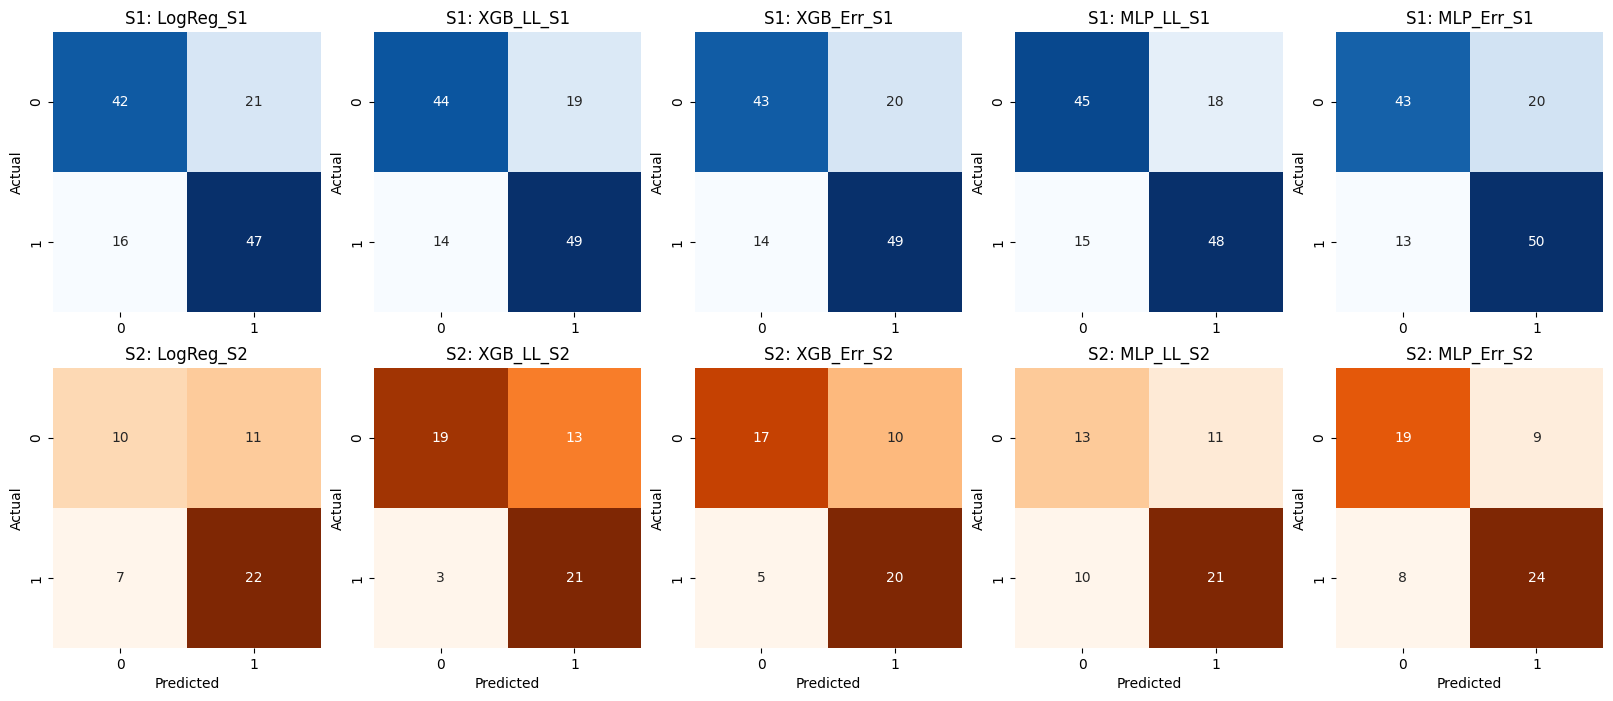

In [18]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# Strategy 1
for i, (data, name) in enumerate(zip(strat1_data, strat1_models)):
    preds = [1 if p >= 0.5 else 0 for p in data['Prob']]
    cm = confusion_matrix(data['Act'], preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, i], cbar=False)
    axes[0, i].set_ylabel('Actual')
    axes[0, i].set_title(f'S1: {name}')

# Strategy 2
for i, (data, name) in enumerate(zip(strat2_data, strat2_models)):
    preds = [1 if p >= 0.5 else 0 for p in data['Prob']]
    cm = confusion_matrix(data['Act'], preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', ax=axes[1, i], cbar=False)
    axes[1, i].set_xlabel('Predicted')
    axes[1, i].set_ylabel('Actual')
    axes[1, i].set_title(f'S2: {name}')


plt.show()

Profit distribution

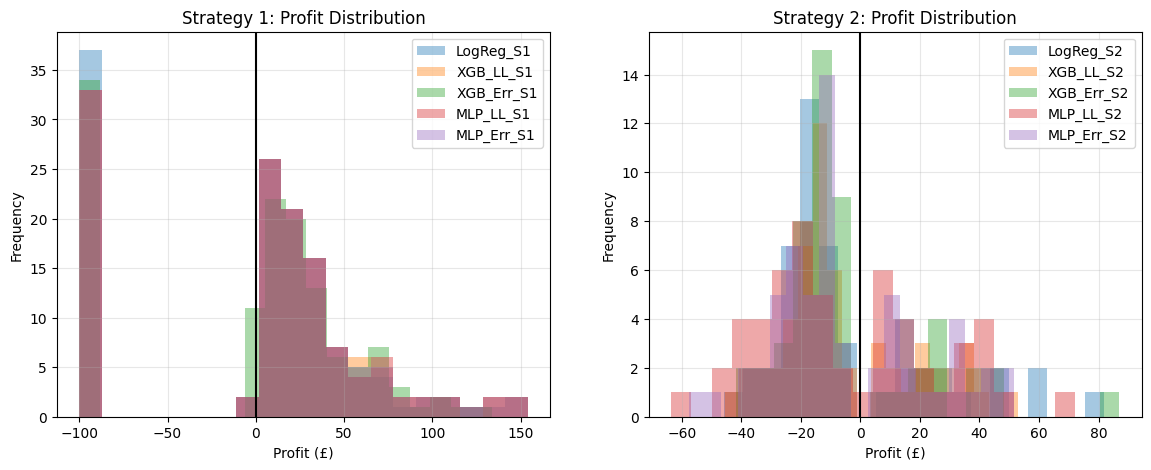

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Strategy 1
for data, name in zip(strat1_data, strat1_models):
    profits = [data['Winnings'][i] - data['Staked'][i] for i in range(len(data['Winnings']))]
    axes[0].hist(profits, bins=20, alpha=0.4, label=name)

axes[0].axvline(x=0, color='black')
axes[0].set_xlabel('Profit (£)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Strategy 1: Profit Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Strategy 2
for data, name in zip(strat2_data, strat2_models):
    profits = [data['Winnings'][i] - data['Staked'][i] for i in range(len(data['Winnings'])) if data['Staked'][i] > 0] #only look at when we placed a bet
    axes[1].hist(profits, bins=20, alpha=0.4, label=name)

axes[1].axvline(x=0, color='black')
axes[1].set_xlabel('Profit (£)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Strategy 2: Profit Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.show()